# What is Jupyter

Jupyter notebooks combine software code, computational output, explanatory text, and rich content in a single document. Notebooks allow in-browser editing and execution of code and display computation results. A notebook is saved with an .ipynb extension. The Jupyter Notebook project supports dozens of programming languages, its name reflecting support for Julia (Ju), Python (Py), and R.


# What do I need to get started with Jupyter?


The Jupyter Notebook project supports many programming languages. We’ll use IPython in this example. It uses the same syntax as Python but provides a more interactive experience. You’ll need the following Python libraries to do the mathematical computations needed for machine learning:

- NumPy: For creating and manipulating vectors and matrices.
- Pandas: For analyzing data and for data wrangling or munging. Pandas takes data such as a CSV file or a database, and creates from it a Python object called a DataFrame. A `DataFrame` is the central data structure in the Pandas API and is similar to a spreadsheet as follows:
  - A `DataFrame` stores data in cells.
  - A `DataFrame` has named columns (usually) and numbered rows.
- Matplotlib: For visualizing data.
- Sklern: For supervised and unsupervised learning. This library provides various tools for model fitting, data preprocessing, model selection, and model evaluation. It has built-in machine learning algorithms and models called estimators. Each estimator can be fitted to some data using its `fit` method.


# What are we doing today?

Workflow we will be following today

![workflow](https://developers.redhat.com/sites/default/files/blog/2021/03/Dzone_ML_flow1.png)


First, get python installed.

Then run `pip install pandas pyplot matplotlib sklearn`


## MANUela Anomaly ML Model

Goal: Build a machine lerning model that detects anomalies in sensor vibration data

![anomalies](https://raw.githubusercontent.com/sa-mw-dach/manuela/master/docs/images/manuela-anomalies.png)

**Outline:**

### Read and preview the labeled data
- Read data from disk
- Preview the raw data
- Visualize vibration and anomalies

### Data wrangling
- Convert time series data into small episodes that can be used for supervised learning.
- Explore the new data format

### Model training
- Prepare the data for modeling, training and testing
- Train and validate model

### Save the new model
- Save model to disk
- Commit and push to git

###  Model serving during runtime
- View the warpper code for the model serving with Seldon



## Read data from disk

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('raw-data.csv')
df['time'] = pd.to_datetime(df['ts'],unit='ms')
df.set_index('time', inplace=True)
df.drop(columns=['ts'], inplace=True)

### Preview the raw data
Quick view on the data. It is a dataframe with a 
- timeseries, 
- an id for the pump, 
- the vibration value
- and a label indicating an anmonaly.

In [52]:
df.tail(5) # ASSIGNMENT 1: List last 10 records of the dataframe!

,id,value,label
time,,,
2020-04-23 13:19:38.000,pump-2,43.276667,1
2020-04-23 13:19:39.617,pump-1,15.709151,0
2020-04-23 13:19:42.999,pump-2,16.214949,0
2020-04-23 13:19:44.617,pump-1,15.393048,0
2020-04-23 13:19:47.999,pump-2,14.855999,0


### Visualize data
- The uppper graph show a subset of the vibration data.
- The lower graph illustrates the anomalies (1 = anomaly, 0 = normal)

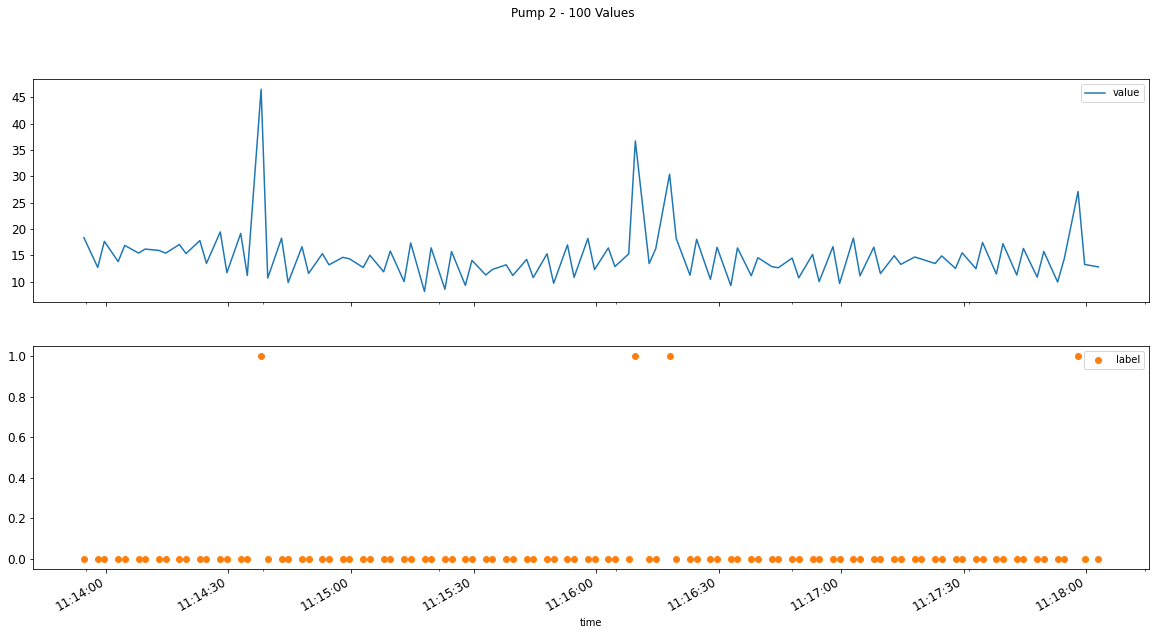

In [53]:
df21 = df.head(100)
df21.plot(figsize=(20,10), fontsize=12,subplots=True, style=["-","o"], title = "Pump 2 - 100 Values")
plt.show()

## Data Wrangling
Goal: Convert time series data into small episodes that can be uses for supervised learning.

In [54]:
#
# Few helper functions
#

# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    f = []
    for x in range(1,n+1):
        f.append("F"+str(x))
    f.append("L")
    return f

# Create empty data frame
def create_empty_df(n):
    d= ([0.]*n)
    d.append(0)
    dfx = pd.DataFrame([d], columns=get_columns(n))
    dfx.drop(dfx.index[0], inplace=True)
    return dfx

# Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    #vals.append(label)    
    dfx = pd.DataFrame([vals+[label]], columns=get_columns(len(vals)))
    return dfx




Create a new dataframe: Rows represent the last x (length) value and the label.


```
| tz | value | label |
|----|-------|-------|
| .. |   ... |   .   |
| 04 |   6.2 |   0   |
| 05 |   7.2 |   0   |
| 06 |   5.1 |   0   |
| 07 |   6.4 |   0   |
| 08 |   2.2 |   0   |
| 09 |  12.4 |   0   |
| 10 |   8.4 |   1   |
| .. |   ... |   .   |
```

Convert to episodes with lenght = 5

```

| F1 | F2 | F3 | F4 | F5 |  L  |
|----|----|----|----|----|---- |
| 6.2| 7.2| 5.1| 6.4| 2.2|  0  |
| 7.2| 5.1| 6.4| 2.2|12.4|  1  |
| 5.1| 6.4| 2.2|12.4| 8.4|  0  |


```



In [55]:
length = 5 # ASSIGNMENT 2:  Try different lengths and see what it changes below

df_epis = create_empty_df(length)

for id in df.id.unique():
    print("Convert data for: ", id)
    
    df2 = df.loc[df['id'] == id]

    epi = []
    for index, row in df2.iterrows():
        # print('%6.2f, %d' % (row['value'], row['label']))
        epi.append(row['value'])
        if len(epi) == length :
            df_row = create_df(epi,row['label'] )
            df_epis = df_epis.append(df_row, ignore_index=True)
            del(epi[0])

Convert data for:  pump-1
Convert data for:  pump-2


### Explore the new data format
Show episodes of the lengh 5 and the label in the last column

In [56]:
df_epis.tail(5) #Assignment: What do F1, F2, etc represent?

,F1,F2,F3,F4,F5,L
3009,12.804910,14.626118,14.697982,16.386558,17.361092,0
3010,14.626118,14.697982,16.386558,17.361092,18.764962,0
3011,14.697982,16.386558,17.361092,18.764962,43.276667,1
3012,16.386558,17.361092,18.764962,43.276667,16.214949,0
3013,17.361092,18.764962,43.276667,16.214949,14.855999,0


The data is ready for supervised learning

## Prepare the data for modeling, training and testing
- Identify and separate the feature and target columns
- Training and Testing Data Split

### Identify feature and target columns
Like many ML libraries, sklern requires separted feature (X) and target (Y) columns. 

In [57]:
# Extract feature columns
feature_cols = list(df_epis.columns[:-1])

# Extract target column 'label'
target_col = df_epis.columns[-1]

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df_epis[feature_cols]
y_all = df_epis[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


### Training and Testing Data Split
It is best best practise to have separate sets for the training and test.

In [58]:
from sklearn.model_selection import train_test_split

control_test_size = 0.99 # ASSIGNMENT: Tinker with this value(always less than 1 and see what happens)


X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=control_test_size, random_state=1231)


# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

# ASSIGNMENT: Why are we printing these two anomaly rates?
print ("Anomaly rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print ("Anomaly rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Training set has 30 samples.
Testing set has 2984 samples.
Anomaly rate of the training set: 3.33%
Anomaly rate of the testing set: 2.78%


### Model Training

Let's do a quick model training with a Decision Tree Classifier.

In [59]:
# from sklearn import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

my_random_seed = 43

# Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=my_random_seed)

# train the classifier
model.fit(X_train, y_train)

# Predict with the test data
y_predict = model.predict(X_test)

# Determine the accuracy score
accuracy_score = accuracy_score(y_test, y_predict)

print ("Accuracy score for the trained model: {:.10f}.".format(accuracy_score))

Accuracy score for the trained model: 0.9574396783.


... the accuracy is pretty good.


### Save model to disk
- Save the model
- Load the model again and check that it works

In [60]:
from joblib import dump, load

filename = 'model.joblib'
dump(model, open(filename, 'wb'))

# Validate that the model can be loaded

# load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test) # ASSIGNMENT: Where does X_test and y_test come from? Think what can you use instead?
print("Score:", result)

Score: 0.9574396782841823


### Commit the new model to git
The new model is saved in git so we can reuse it!
